In [118]:
import numpy as np
import random
import copy
import gym
import pandas as pd
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [35]:
seed = 235
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Environment TicTacToe из ноутбука 6-ой лекции

In [36]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i, j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getHash()

In [37]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s, a]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if (s, (0, 0)) in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s, a])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, actions)

In [38]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        actions = [tuple(a) for a in actions]
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

### Часть первая: крестики-нолики при помощи Q-обучения

### 3x3x3 Q-learning

In [39]:
env_333 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [40]:
def inv_state(s):
    return ''.join([str(2 - int(n)) for n in s])

In [41]:
class randomAgent(object):
    def __init__(self):
        self.index_best_action = True
        pass

    def get_best_action(self, state, n_actions=None):
        if n_actions is None:
            n_actions = np.sum(np.array(list(state)) == '1')
        return np.random.randint(n_actions)

In [42]:
random_agent = randomAgent()

In [43]:
def test_one_game(env, pi_crosses, pi_naughts):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        n_actions = len(actions)
        if env.curTurn == 1:
            if pi_crosses.index_best_action:
                a = actions[pi_crosses.get_best_action(s, n_actions)]
            else:
                a = pi_crosses.get_best_action(s)
        else:
            if pi_naughts.index_best_action:
                a = actions[pi_naughts.get_best_action(inv_state(s), n_actions)]
            else:
                a = pi_naughts.get_best_action(inv_state(s))
        observation, reward, done, info = env.step(a)
        if reward < -1:
            print("Ход в занятую клетку")
    return reward

In [44]:
def test_policy(env, pi_crosses, pi_naughts, num_games=1000):
    crosses_wins = 0
    naughts_wins = 0
    for _ in range(num_games):
        reward = test_one_game(env, pi_crosses, pi_naughts)
        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            naughts_wins += 1
    return crosses_wins / num_games, naughts_wins / num_games

In [45]:
class QLearningAgent:
    def __init__(self, alpha, gamma):
        self.index_best_action = True

        self.Qvalues = {}
        self.alpha = alpha
        self.gamma = gamma
        
    def get_n_actions(self, state):
        return np.sum(np.array(list(state)) == '1')        
        
    def get_Qs(self, state, n_actions=None):
        if state not in self.Qvalues:
            if n_actions is None:
                n_actions = self.get_n_actions(state)
            self.Qvalues[state] = np.random.random(n_actions) * 0.01 - 0.005
        return self.Qvalues[state]

    def get_V(self, state):
        return np.max(self.get_Qs(state))

    def update(self, state, n_action, reward, next_state):
        Q = self.get_Qs(state)[n_action]
        if next_state is None:
            V = 0
        else:
            V = self.get_V(next_state)
            
        self.Qvalues[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_best_action(self, state, n_actions=None):
        return np.argmax(self.get_Qs(state, n_actions))

    # epsilon-greedy action
    def get_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.get_best_action(state, n_actions)
        else:
            if n_actions is None:
                n_actions = self.get_n_actions(state)
            return np.random.randint(n_actions)

In [46]:
def QL_train(env, QL_agent, max_epsilon, t_max, perf_interval):
    perf_crosses = []
    perf_naughts = []
    for t in range(t_max):
        epsilon = max_epsilon * (t_max - t) / t_max

        if t % perf_interval == 0:
            p, _ = test_policy(env, QL_agent, random_agent)
            perf_crosses.append((t, p))
            _, p = test_policy(env, random_agent, QL_agent)
            perf_naughts.append((t, p))
            
        done = False
        env.reset()

        state_0, actions_0 = env.getHash(), env.getEmptySpaces()
        n_action_0 = QL_agent.get_action(state_0, epsilon, len(actions_0))
        observation, reward, done, info = env.step(actions_0[n_action_0])
        state_1, actions_1 = observation[0], observation[1]
        curTurn = env.curTurn
        state_1 = inv_state(state_1)
        while not done:
            n_action_1 = QL_agent.get_action(state_1, epsilon, len(actions_1))
            observation, reward, done, info = env.step(actions_1[n_action_1])
            if done: 
                QL_agent.update(state_0, n_action_0, -reward * curTurn, None)
                QL_agent.update(state_1, n_action_1, reward * curTurn, None)
                break

            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = inv_state(next_state)
                
            QL_agent.update(state_0, n_action_0, reward, next_state)
            state_0, actions_0 = state_1, actions_1
            state_1, actions_1 = next_state, observation[1]
            n_action_0 = n_action_1
            
    return perf_crosses, perf_naughts

In [47]:
def plot_results(perf_crosses, perf_naughts):
    steps = [x[0] for x in perf_crosses]
    rewards_crosses = [x[1] for x in perf_crosses]
    rewards_naughts = [x[1] for x in perf_naughts]
    plt.plot(steps, rewards_crosses, label='крестики')
    plt.plot(steps, rewards_naughts, label='нолики')
    plt.grid()
    plt.xlabel("Шаг обучения")
    plt.ylabel("Доля выигрышей")
    plt.title("Игры против RANDOM-policy")
    plt.legend()
    plt.ylim(0, 1.1)

In [48]:
max_epsilon = 0.7
t_max = 100000
perf_interval = t_max // 10
alpha = 0.1
gamma = 1.0
QL_agent_333 = QLearningAgent(alpha, gamma)
perf_crosses, perf_naughts = QL_train(env_333, QL_agent_333, max_epsilon, t_max, perf_interval)

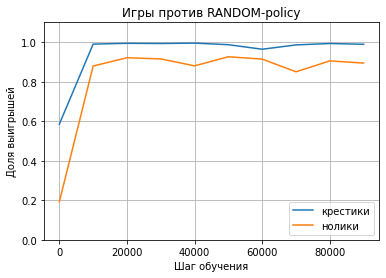

In [49]:
plot_results(perf_crosses, perf_naughts)

In [50]:
print("Крестики против RANDOM: " + str(test_policy(env_333, QL_agent_333, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_333, random_agent, QL_agent_333)))
print("Крестики против Ноликов: " + str(test_policy(env_333, QL_agent_333, QL_agent_333)))

Крестики против RANDOM: (0.925, 0.005)
Нолики против RANDOM: (0.003, 0.854)
Крестики против Ноликов: (0.0, 0.0)


### 4x4x4 Q-learning

In [53]:
env_444 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

In [54]:
max_epsilon = 0.7
t_max = 1000000
perf_interval = t_max // 10
alpha = 0.1
gamma = 1.
QL_agent_444 = QLearningAgent(alpha, gamma)
perf_crosses, perf_naughts = QL_train(env_444, QL_agent_444, max_epsilon, t_max, perf_interval)

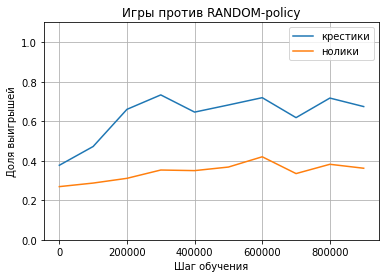

In [55]:
plot_results(perf_crosses, perf_naughts)

In [56]:
print("Крестики против RANDOM: " + str(test_policy(env_444, QL_agent_444, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_444, random_agent, QL_agent_444)))
print("Крестики против Ноликов: " + str(test_policy(env_444, QL_agent_444, QL_agent_444)))

Крестики против RANDOM: (0.523, 0.148)
Нолики против RANDOM: (0.254, 0.379)
Крестики против Ноликов: (0.0, 0.0)


### Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3.	Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4.	Реализуйте Double DQN и/или Dueling DQN.


In [57]:
class ReplayBufferSet(Dataset):
    def __init__(self, length, environment):
        self.len = length
        self.env = environment
        
        self.store_index = 0
        
        self.s = np.zeros((length, 2, environment.n_rows, environment.n_cols))
        self.a = np.zeros((length, 2))
        self.r = np.zeros(length)
        self.done = np.zeros(length)
        self.next_s = np.zeros((length, 2, environment.n_rows, environment.n_cols))
        
        counter = 0
        while counter < length:
            self.env.reset()
            state_0 = copy.deepcopy(self.env.board)
            actions_0 = self.env.getEmptySpaces()
            action_0 = random.choice(actions_0)
            observation, reward, done, info = self.env.step(action_0)
            curTurn = self.env.curTurn
            state_1 = copy.deepcopy(self.env.board) * curTurn
            actions_1 = observation[1]
            while not done:
                action_1 = random.choice(actions_1)
                observation, reward, done, info = self.env.step(action_1)

                curTurn = self.env.curTurn
                next_state = copy.deepcopy(self.env.board) * curTurn
                
                if done: 
                    self.s[counter, 0, :, :] = state_0 == 1
                    self.s[counter, 1, :, :] = state_0 == -1
                    self.a[counter, :] = action_0
                    self.r[counter] = reward * curTurn
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1
                    if counter >= length:
                        break
                    self.s[counter, 0, :, :] = state_1 == 1
                    self.s[counter, 1, :, :] = state_1 == -1
                    self.a[counter, :] = action_1
                    self.r[counter] = -reward * curTurn
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1
                    break
                else:
                    self.s[counter, 0, :, :] = state_0 == 1
                    self.s[counter, 1, :, :] = state_0 == -1
                    self.a[counter, :] = action_0
                    self.r[counter] = 0
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1

                if counter >= length:
                    break

                state_0, actions_0 = state_1, actions_1
                state_1, actions_1 = next_state, observation[1]
                action_0 = action_1    

        self.s = torch.from_numpy(self.s).float()
        self.next_s = torch.from_numpy(self.next_s).float()

    def __getitem__(self, index):
        a = self.a[index]
        r = self.r[index]
        done = self.done[index]

        if type(index) == slice:
            index = range(self.len)[index]
        index = torch.from_numpy(np.array(index)).long()

        s = torch.index_select(self.s, 0, index)
        next_s = torch.index_select(self.next_s, 0, index)

        return {'s': s, 'a': a, 'r': r, 'done': done, 'next_s': next_s}
    
    def __len__(self):
        return self.len
    
    def store(self, s, a, r, done, next_s):
        self.s[self.store_index, :, :, :] = s
        self.a[self.store_index, :] = a
        self.r[self.store_index] = r
        self.done[self.store_index] = done
        self.next_s[self.store_index, :, :, :] = next_s
        self.store_index = (self.store_index + 1) % self.len

In [58]:
replay_buffer_333 = ReplayBufferSet(10000, env_333)

In [59]:
# трехслойная сверточная сеть
class Conv3net(nn.Module):
    def __init__(self, n_hid_channels=16):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=2,
                              out_channels=n_hid_channels,
                              kernel_size=3,
                              padding=1
                              )
        
        self.activation_1 = nn.ReLU()
        
        self.conv_2 = nn.Conv2d(in_channels=n_hid_channels,
                              out_channels=n_hid_channels,
                              kernel_size=3,
                              padding=1
                              )

        self.activation_2 = nn.ReLU()
        
        self.conv_3 = nn.Conv2d(in_channels=n_hid_channels,
                              out_channels=1,
                              kernel_size=3,
                              padding=1
                              )
        
        self.activation_3 = nn.Tanh()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation_1(x)
        x = self.conv_2(x)
        x = self.activation_2(x)
        x = self.conv_3(x)
        x = self.activation_3(x)
        return x

In [60]:
class DQNAgent(object):
    def __init__(self, environment):
        self.index_best_action = False
        self.net = Conv3net()
        self.env = environment
        
    def board2matrix(self, board):
        crosses = torch.FloatTensor(board == 1)
        naughts = torch.FloatTensor(board == -1)
        actions = torch.FloatTensor(board == 0)
        m = torch.stack((crosses, naughts))
        return m, actions

    # epsilon-greedy action
    def get_action_from_board(self, board, epsilon):
        if np.random.random() > epsilon:
            m, actions = self.board2matrix(board)
            r = torch.squeeze(self.net(torch.unsqueeze(m, 0)))
            idx = torch.argmax(r - (1 - actions) * 100)
            return self.env.action_from_int(idx)
        else:
            r, c = np.where(board == 0)
            r_idx = np.random.randint(len(r))
            return r[r_idx], c[r_idx]
        
    def get_best_action(self, s):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols))
        m, actions = self.board2matrix(board - 1)
        r = torch.squeeze(self.net(torch.unsqueeze(m, 0)))
        idx = torch.argmax(r - (1 - actions) * 100)
        return self.env.action_from_int(idx)

In [61]:
DQN_agent_333 = DQNAgent(env_333)

In [62]:
def DQN_train(agent, env, replay_buffer, n_games=1000, perf_interval=100, batch_size=1000):
    perf_crosses = []
    perf_naughts = []

    max_epsilon = 0.1
    gamma = 1.0
    opt = torch.optim.Adam(agent.net.parameters())
    loss_function = nn.MSELoss()
    agent.net.eval()
    for counter in range(n_games):
        epsilon = max_epsilon * (n_games - counter) / n_games

        env.reset()
        state_0 = copy.deepcopy(env.board)
        action_0 = agent.get_action_from_board(state_0, epsilon)
        observation, reward, done, info = env.step(action_0)
        curTurn = env.curTurn
        state_1 = copy.deepcopy(env.board) * curTurn
        while not done:
            action_1 = agent.get_action_from_board(state_1, epsilon)
            observation, reward, done, info = env.step(action_1)
            curTurn = env.curTurn
            next_state = copy.deepcopy(env.board) * curTurn

            s, _ = agent.board2matrix(state_0)
            next_s, _ = agent.board2matrix(next_state)
            replay_buffer.store(s, action_0, reward * curTurn, done, next_s)
            
            if done: 
                s, _ = agent.board2matrix(state_1)
                replay_buffer.store(s, action_1, -reward * curTurn, done, next_s)
                break

            state_0 = state_1
            state_1 = next_state
            action_0 = action_1
            
        batch = replay_buffer[random.sample(range(len(replay_buffer)), batch_size)]
        next_actions = ((batch['next_s'][:, 0, :, :] != 1) & 
                        (batch['next_s'][:, 1, :, :] != 1)).long()
        Q_next = torch.squeeze(agent.net(batch['next_s'])).detach()
        V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(Q_next.shape[0], -1), dim = 1)[0]
        y = batch['done'] * batch['r'] + (1 - batch['done']) * V_next.numpy() * gamma
        
        agent.net.train()
        Q = torch.squeeze(agent.net(batch['s']))
        a = torch.LongTensor(batch['a'])
        y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
        
        opt.zero_grad()
        loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
        loss.backward()
        opt.step()
        agent.net.eval()
        
        if counter % perf_interval == 0:
            p, _ = test_perf(env, agent, random_agent)
            perf_crosses.append((counter, p))
            _, p = test_perf(env, random_agent, agent)
            perf_naughts.append((counter, p))

    return perf_crosses, perf_naughts

In [63]:
perf_crosses, perf_naughts = DQN_train(DQN_agent_333, env_333, replay_buffer_333)

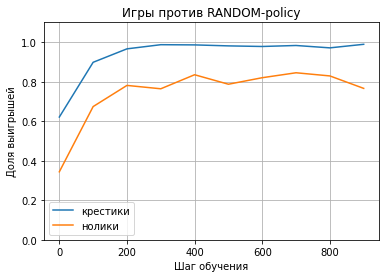

In [64]:
plot_results(perf_crosses, perf_naughts)

In [65]:
print("Крестики против RANDOM: " + str(test_policy(env_333, DQN_agent_333, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_333, random_agent, DQN_agent_333)))
print("Крестики против Ноликов: " + str(test_policy(env_333, DQN_agent_333, DQN_agent_333)))

Крестики против RANDOM: (0.988, 0.004)
Нолики против RANDOM: (0.124, 0.793)
Крестики против Ноликов: (0.0, 1.0)


### DQN 4x4x4

In [66]:
replay_buffer_444 = ReplayBufferSet(10000, env_444)
DQN_agent_444 = DQNAgent(env_444)
perf_crosses, perf_naughts = DQN_train(DQN_agent_444, env_444, replay_buffer_444)

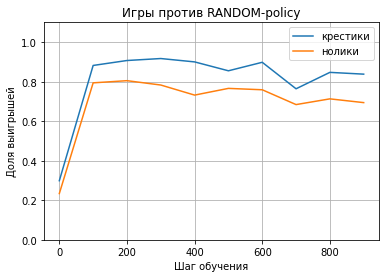

In [67]:
plot_results(perf_crosses, perf_naughts)

In [68]:
print("Крестики против RANDOM: " + str(test_policy(env_444, DQN_agent_444, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_444, random_agent, DQN_agent_444)))
print("Крестики против Ноликов: " + str(test_policy(env_444, DQN_agent_444, DQN_agent_444)))

Крестики против RANDOM: (0.862, 0.025)
Нолики против RANDOM: (0.076, 0.714)
Крестики против Ноликов: (1.0, 0.0)


### DQN 5x5x5

In [69]:
env_555 = TicTacToe(5, 5, 5)
replay_buffer_555 = ReplayBufferSet(10000, env_555)
DQN_agent_555 = DQNAgent(env_555)
perf_crosses, perf_naughts = DQN_train(DQN_agent_555, env_555, replay_buffer_555, n_games=10000, perf_interval=1000)

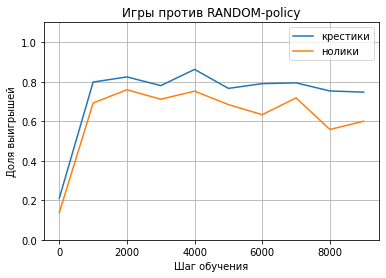

In [70]:
plot_results(perf_crosses, perf_naughts)

In [71]:
print("Крестики против RANDOM: " + str(test_policy(env_555, DQN_agent_555, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_555, random_agent, DQN_agent_555)))
print("Крестики против Ноликов: " + str(test_policy(env_555, DQN_agent_555, DQN_agent_555)))

Крестики против RANDOM: (0.674, 0.028)
Нолики против RANDOM: (0.065, 0.557)
Крестики против Ноликов: (0.0, 1.0)


### Double DQN

In [72]:
class DoubleQNAgent(object):
    def __init__(self, environment):
        self.index_best_action = False
        self.net_a = Conv3net()
        self.net_b = Conv3net()
        self.env = environment
        
    def board2matrix(self, board):
        crosses = torch.FloatTensor(board == 1)
        naughts = torch.FloatTensor(board == -1)
        actions = torch.FloatTensor(board == 0)
        m = torch.stack((crosses, naughts))
        return m, actions

    # epsilon-greedy action
    def get_action_from_board(self, board, epsilon, update=0):
        if np.random.random() > epsilon:
            m, actions = self.board2matrix(board)
            if update == 1:
                r = torch.squeeze(self.net_a(torch.unsqueeze(m, 0)))
            elif update == -1:
                r = torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))
            else:
                r = (torch.squeeze(self.net_a(torch.unsqueeze(m, 0))) + torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))) / 2.
            idx = torch.argmax(r - (1 - actions) * 100)
            return self.env.action_from_int(idx)
        else:
            r, c = np.where(board == 0)
            r_idx = np.random.randint(len(r))
            return r[r_idx], c[r_idx]
        
    def get_best_action(self, s):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols))
        m, actions = self.board2matrix(board - 1)
        r = (torch.squeeze(self.net_a(torch.unsqueeze(m, 0))) + torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))) / 2.
        idx = torch.argmax(r - (1 - actions) * 100)
        return self.env.action_from_int(idx)

In [73]:
double_agent_333 = DoubleQNAgent(env_333)

In [74]:
def double_QN_train(agent, env, replay_buffer, n_games=1000, perf_interval=100, batch_size=100):
    perf_crosses = []
    perf_naughts = []

    max_epsilon = 0.1
    gamma = 1.0
    opt_a = torch.optim.Adam(agent.net_a.parameters())
    opt_b = torch.optim.Adam(agent.net_b.parameters())
    loss_function = nn.MSELoss()
    agent.net_a.eval()
    agent.net_b.eval()
    for counter in range(n_games):
        epsilon = max_epsilon * (n_games - counter) / n_games

        env.reset()
        state_0 = copy.deepcopy(env.board)
        action_0 = agent.get_action_from_board(state_0, epsilon)
        observation, reward, done, info = env.step(action_0)
        curTurn = env.curTurn
        state_1 = copy.deepcopy(env.board) * curTurn
        while not done:
            action_1 = agent.get_action_from_board(state_1, epsilon)
            observation, reward, done, info = env.step(action_1)
            curTurn = env.curTurn
            next_state = copy.deepcopy(env.board) * curTurn

            s, _ = agent.board2matrix(state_0)
            next_s, _ = agent.board2matrix(next_state)
            replay_buffer.store(s, action_0, reward * curTurn, done, next_s)
            
            if done: 
                s, _ = agent.board2matrix(state_1)
                replay_buffer.store(s, action_1, -reward * curTurn, done, next_s)
                break

            state_0 = state_1
            state_1 = next_state
            action_0 = action_1
            
        batch = replay_buffer[random.sample(range(len(replay_buffer)), batch_size)]
        next_actions = ((batch['next_s'][:, 0, :, :] != 1) & 
                        (batch['next_s'][:, 1, :, :] != 1)).long()

        if np.random.random() > 0.5:
            Q_next = torch.squeeze(agent.net_b(batch['next_s'])).detach()
            V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(
                Q_next.shape[0], -1), dim = 1)[0]
            y = batch['done'] * batch['r'] +\
                (1 - batch['done']) * V_next.numpy() * gamma

            agent.net_a.train()
            Q = torch.squeeze(agent.net_a(batch['s']))
            a = torch.LongTensor(batch['a'])
            y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
            opt_a.zero_grad()
            loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
            loss.backward()
            opt_a.step()
            agent.net_a.eval()
        else:
            Q_next = torch.squeeze(agent.net_a(batch['next_s'])).detach()
            V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(
                Q_next.shape[0], -1), dim = 1)[0]
            y = batch['done'] * batch['r'] +\
                (1 - batch['done']) * V_next.numpy() * gamma
            agent.net_b.train()
            Q = torch.squeeze(agent.net_b(batch['s']))
            a = torch.LongTensor(batch['a'])
            y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
            opt_b.zero_grad()
            loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
            loss.backward()
            opt_b.step()
            agent.net_b.eval()

        if counter % perf_interval == 0:
            p, _ = test_perf(env, agent, random_agent)
            perf_crosses.append((counter, p))
            _, p = test_perf(env, random_agent, agent)
            perf_naughts.append((counter, p))

    return perf_crosses, perf_naughts

In [75]:
replay_buffer_333 = ReplayBufferSet(10000, env_333)
perf_crosses, perf_naughts = double_QN_train(double_agent_333, env_333, replay_buffer_333)

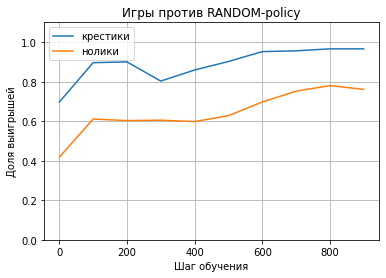

In [76]:
plot_results(perf_crosses, perf_naughts)

In [77]:
print("Крестики против RANDOM: " + str(test_policy(env_333, double_agent_333, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_333, random_agent, double_agent_333)))
print("Крестики против Ноликов: " + str(test_policy(env_333, double_agent_333, double_agent_333)))

Крестики против RANDOM: (0.937, 0.022)
Нолики против RANDOM: (0.201, 0.734)
Крестики против Ноликов: (1.0, 0.0)


### Double DQN 4x4x4

In [78]:
replay_buffer_444 = ReplayBufferSet(10000, env_444)
double_agent_444 = DoubleQNAgent(env_444)
perf_crosses, perf_naughts = double_QN_train(double_agent_444, env_444, replay_buffer_444)

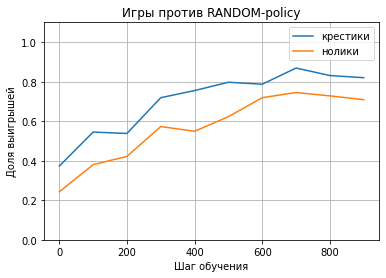

In [79]:
plot_results(perf_crosses, perf_naughts)

In [81]:
print("Крестики против RANDOM: " + str(test_policy(env_444, double_agent_444, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_444, random_agent, double_agent_444)))
print("Крестики против Ноликов: " + str(test_policy(env_444, double_agent_444, double_agent_444)))

Крестики против RANDOM: (0.834, 0.068)
Нолики против RANDOM: (0.137, 0.703)
Крестики против Ноликов: (0.0, 1.0)


### Double DQN 5x5x5

In [82]:
replay_buffer_555 = ReplayBufferSet(10000, env_555)
double_agent_555 = DoubleQNAgent(env_555)
perf_crosses, perf_naughts = double_QN_train(double_agent_555, env_555, replay_buffer_555, n_games=10000, perf_interval=1000)

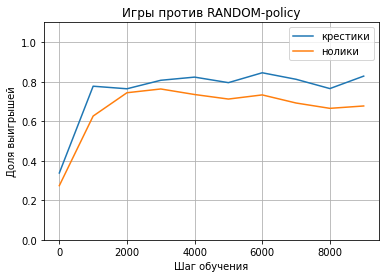

In [83]:
plot_results(perf_crosses, perf_naughts)

In [84]:
print("Крестики против RANDOM: " + str(test_policy(env_555, double_agent_555, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_555, random_agent, double_agent_555)))
print("Крестики против Ноликов: " + str(test_policy(env_555, double_agent_555, double_agent_555)))

Крестики против RANDOM: (0.829, 0.023)
Нолики против RANDOM: (0.048, 0.7)
Крестики против Ноликов: (1.0, 0.0)


### Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5.	Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6.	Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


In [85]:
class MCTSTreeNode(object):

    def __init__(self, env, board, parent=None):
        self.state_env = TicTacToe(env.n_rows, env.n_cols, env.n_win)
        self.state_env.board = copy.deepcopy(board)
        self.state_env.isTerminal()
        self.parent = parent
        self.children = []
        self.n = 0
        self.q = 0
        self.actions = list(self.state_env.getEmptySpaces())

    def best_child(self, c_param=1):
        choices_weights = [
            (-c.q / c.n) + c_param * np.sqrt((2 * np.log(self.n) / c.n))
            for c in self.children
        ]
        return np.argmax(choices_weights)

    def expand(self):
        action = self.actions.pop(0)
        next_board = copy.deepcopy(self.state_env.board)
        next_board[action[0], action[1]] = self.state_env.curTurn
        child_node = MCTSTreeNode(self.state_env, next_board, parent=self)
        child_node.state_env.curTurn = -self.state_env.curTurn
        self.children.append(child_node)
        return child_node

    def rollout(self):
        rollout_env = TicTacToe(self.state_env.n_rows, self.state_env.n_cols, self.state_env.n_win)
        rollout_env.board = copy.deepcopy(self.state_env.board)
        rollout_env.curTurn = self.state_env.curTurn
        reward = rollout_env.isTerminal()
        done = rollout_env.gameOver
        random_actions = list(np.random.permutation(rollout_env.getEmptySpaces()))
        while not done:
            action = random_actions.pop()
            observation, reward, done, info = rollout_env.step(action)
        return reward * self.state_env.curTurn

    def backprop(self, result):
        self.n += 1.
        self.q += result
        if self.parent:
            self.parent.backprop(-result)

In [86]:
class MCTSAgent(object):
    def __init__(self, environment, n_simulations):
        self.index_best_action = True
        self.env = environment
        self.n_simulations = n_simulations
        
    def get_best_action(self, s, n_actions):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols)) - 1
        
        tree_root = MCTSTreeNode(self.env, board)
 
        for _ in range(self.n_simulations):            
            v = tree_root
            while not v.state_env.gameOver:
                if len(v.actions) > 0:
                    v = v.expand()
                else:
                    v = v.children[v.best_child()]
            reward = v.rollout()
            v.backprop(reward)
        return tree_root.best_child(c_param=0)

### Доска 3x3x3

In [87]:
MCTS_agent_333 = MCTSAgent(env_333, n_simulations=100)

In [88]:
print("Крестики против RANDOM: " + str(test_policy(env_333, MCTS_agent_333, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_333, random_agent, MCTS_agent_333)))
print("Крестики против Ноликов: " + str(test_policy(env_333, MCTS_agent_333, MCTS_agent_333)))

Крестики против RANDOM: (0.968, 0.0)
Нолики против RANDOM: (0.382, 0.539)
Крестики против Ноликов: (1.0, 0.0)


### Доска 4x4x4

In [89]:
MCTS_agent_444 = MCTSAgent(env_444, n_simulations=100)

In [90]:
print("Крестики против RANDOM: " + str(test_policy(env_444, MCTS_agent_444, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_444, random_agent, MCTS_agent_444)))
print("Крестики против Ноликов: " + str(test_policy(env_444, MCTS_agent_444, MCTS_agent_444)))

Крестики против RANDOM: (0.896, 0.033)
Нолики против RANDOM: (0.007, 0.803)
Крестики против Ноликов: (0.066, 0.736)


### Доска 5x5x5

In [91]:
MCTS_agent_555 = MCTSAgent(env_555, n_simulations=100)

In [92]:
print("Крестики против RANDOM: " + str(test_policy(env_555, MCTS_agent_555, random_agent)))
print("Нолики против RANDOM: " + str(test_policy(env_555, random_agent, MCTS_agent_555)))
print("Крестики против Ноликов: " + str(test_policy(env_555, MCTS_agent_555, MCTS_agent_555)))

Крестики против RANDOM: (0.913, 0.002)
Нолики против RANDOM: (0.046, 0.859)
Крестики против Ноликов: (1.0, 0.0)


#### Сравнение агентов 3x3

In [122]:
policy = [random_agent, QL_agent_333, DQN_agent_333, double_agent_333, MCTS_agent_333]

In [ ]:
res = np.full((5, 5), '                        ')
for policy1 in range(5):
    for policy2 in range(5):
        r = test_policy(env_333, policy[policy1], policy[policy2])
        #print(str(r))
        res[policy1, policy2] = str(r)

In [126]:
pd.DataFrame(res, columns=['random', 'Q', 'DQN', 'Double', 'MCTS'], index=['random', 'Q', 'DQN', 'Double', 'MCTS'])

,random,Q,DQN,Double,MCTS
random,"(0.56, 0.304)","(0.0, 0.871)","(0.13, 0.784)","(0.213, 0.719)","(0.378, 0.548)"
Q,"(0.94, 0.007)","(0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)"
DQN,"(0.984, 0.001)","(0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)"
Double,"(0.963, 0.011)","(0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)"
MCTS,"(0.974, 0.0)","(0.0, 0.001)","(0.454, 0.0)","(0.956, 0.001)","(1.0, 0.0)"


#### Сравнение агентов 4x4

In [127]:
policy = [random_agent, QL_agent_444, DQN_agent_444, double_agent_444, MCTS_agent_444]

In [128]:
res = np.full((5, 5), '                        ')
for policy1 in range(5):
    for policy2 in range(5):
        r = test_policy(env_444, policy[policy1], policy[policy2])
        res[policy1, policy2] = str(r)

In [129]:
pd.DataFrame(res, columns=['random', 'Q', 'DQN', 'Double', 'MCTS'], index=['random', 'Q', 'DQN', 'Double', 'MCTS'])

,random,Q,DQN,Double,MCTS
random,"(0.3, 0.285)","(0.252, 0.366)","(0.074, 0.736)","(0.153, 0.676)","(0.005, 0.775)"
Q,"(0.509, 0.168)","(0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.887)"
DQN,"(0.866, 0.038)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.013, 0.154)"
Double,"(0.83, 0.067)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(0.823, 0.177)"
MCTS,"(0.904, 0.03)","(0.625, 0.172)","(0.728, 0.256)","(0.922, 0.076)","(0.073, 0.756)"


#### Сравнение агентов 5x5

In [130]:
policy = [random_agent, DQN_agent_555, double_agent_555, MCTS_agent_555]

In [131]:
res = np.full((4, 4), '                        ')
for policy1 in range(4):
    for policy2 in range(4):
        r = test_policy(env_555, policy[policy1], policy[policy2])
        res[policy1, policy2] = str(r)

In [132]:
pd.DataFrame(res, columns=['random', 'DQN', 'Double', 'MCTS'], index=['random', 'DQN', 'Double', 'MCTS'])

,random,DQN,Double,MCTS
random,"(0.242, 0.153)","(0.053, 0.573)","(0.058, 0.678)","(0.044, 0.859)"
DQN,"(0.681, 0.035)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.95)"
Double,"(0.833, 0.02)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)"
MCTS,"(0.898, 0.001)","(0.0, 0.0)","(0.889, 0.0)","(1.0, 0.0)"
